In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import torch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import libraries
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt


In [3]:
# read in the food csv file
food_df = pd.read_csv("./dataset/food.csv")

# print row and column information
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


In [4]:
len(food_df)

1702235

In [5]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

In [6]:
# define a lambda function to split the string into words and return the length of the resulting list
# apply the lambda function to each row of the column and find the maximum value
# define a lambda function to split the string into words and return the length of the resulting list
max_words = lambda x: len(x.split()) if type(x) == str else 0

# apply the lambda function to each row of the column and find the maximum value
max_words_in_row = food_df['description'].apply(max_words).max()

In [7]:
foods

1                             swanson broth beef
4                          swanson broth chicken
6                             swanson broth beef
7                      prego sauces tomato basil
13                  pepperidge farm bread tuscan
                           ...                  
1702180                         reduced fat milk
1702181                              lowfat milk
1702182    electrolyte sports formula superwater
1702191                             coconut milk
1702199                   smokehouse street corn
Name: description, Length: 590873, dtype: object

In [8]:
# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 4].drop_duplicates()
# print the remaining size
foods.size

64659

In [9]:
foods

1                           swanson broth beef
4                        swanson broth chicken
7                    prego sauces tomato basil
13                pepperidge farm bread tuscan
14                pepperidge farm bread garlic
                          ...                 
1693453                        pork cheek meat
1693888    flavorcrisp seasoned diced potatoes
1694154                         golden nuggets
1694159              pork jowls skinless combo
1694169                   pork sparerib medium
Name: description, Length: 64659, dtype: object

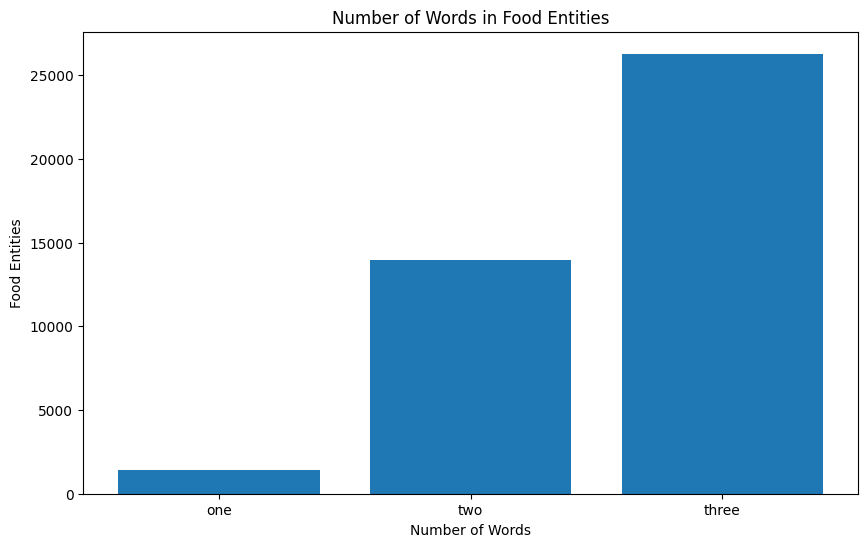

In [10]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]
                             
# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3  ], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size  ])

# label the x-axis instances
ax.set_xticks([1, 2, 3 ])
ax.set_xticklabels(["one", "two", "three" ])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()


In [11]:
len(one_worded_foods)

1402

In [12]:
len(two_worded_foods)

13971

In [13]:
len(three_worded_foods)

26282

In [16]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods._append(two_worded_foods[:round(total_num_foods * 0.30)])._append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1402
2-worded food entities: 935
3-worded food entities: 779


In [17]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

In [20]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": [],
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": [],
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 267

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"] 
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)
    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [21]:
# print the number of food sentences, as well as an example sentence
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

267 one_food sentences: ("I've decided to have some origins kombucha for dessert", {'entities': [(26, 42, 'FOOD')]})
267 two_foods sentences: ('I made a salami and mocktails for lunch', {'entities': [(9, 15, 'FOOD'), (20, 29, 'FOOD')]})
267 three_foods sentences: ('I had a almond fudge brownie, a seafood dip and passata at home', {'entities': [(8, 28, 'FOOD'), (32, 43, 'FOOD'), (48, 55, 'FOOD')]})


In [22]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

974 one_food items: ("There's stir fry for breakfast in the bowl this morning", {'entities': [(8, 16, 'FOOD')]})
104 two_foods items: ('I had a bowl of gummi worms with sorbetto and I wanted to go to the mall today', {'entities': [(16, 27, 'FOOD'), (33, 41, 'FOOD')]})
110 three_foods items: ('I had a ciliegine, a organic pasta fusilli and microwaveable mexican rice at home', {'entities': [(8, 17, 'FOOD'), (21, 42, 'FOOD'), (47, 73, 'FOOD')]})


In [23]:
# read in the revision data (just used a random article dataset from a different course I had taken)
npr_df = pd.read_csv("./dataset/npr.csv")

# print row and column information
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [24]:
# create an nlp object as we'll use this to seperate the sentences and identify existing entities
nlp = en_core_web_lg.load()

In [25]:
revision_texts = []
# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
        # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [26]:
revisions = []
# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [27]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

In [28]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 801
REVISION 1481
COMBINED 2282


In [29]:
from spacy.training import Example

nlp = en_core_web_lg.load()

# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 60
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    # create a list of Example objects
    examples = []
    for text, annotation in TRAIN_DATA:
        examples.append(Example.from_dict(nlp.make_doc(text), annotation))

    # train the model
    for epoch in range(epochs):
        losses = {}
        batches = minibatch(examples, size=32)
        for batch in batches:
            nlp.update(batch, sgd=optimizer, drop=0.35, losses=losses)
        print("Losses ({}/{})".format(epoch + 1, epochs), losses)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I'm eating a mint " with entities "[(13, 18, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I had a bowl of dry coppa " with entities "[(16, 26, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the tex

Losses (1/60) {'ner': 4057.9739722885383}
Losses (2/60) {'ner': 4052.905050382668}
Losses (3/60) {'ner': 3418.113289822346}
Losses (4/60) {'ner': 2300.4325124277525}
Losses (5/60) {'ner': 1964.7864723411208}
Losses (6/60) {'ner': 1971.2036746844838}
Losses (7/60) {'ner': 1849.756130384705}
Losses (8/60) {'ner': 1644.0842321770567}
Losses (9/60) {'ner': 1376.065799226806}
Losses (10/60) {'ner': 1386.833510933662}
Losses (11/60) {'ner': 1278.7578454589277}
Losses (12/60) {'ner': 1103.566785363306}
Losses (13/60) {'ner': 1174.8007038007565}
Losses (14/60) {'ner': 1087.644544823726}
Losses (15/60) {'ner': 1028.0307809606718}
Losses (16/60) {'ner': 993.6070086322255}
Losses (17/60) {'ner': 954.2847198933175}
Losses (18/60) {'ner': 904.0243691151072}
Losses (19/60) {'ner': 851.9809544357445}
Losses (20/60) {'ner': 829.0859430236151}
Losses (21/60) {'ner': 784.8504773382316}
Losses (22/60) {'ner': 730.5058738866126}
Losses (23/60) {'ner': 718.2101669055812}
Losses (24/60) {'ner': 757.68359555

In [30]:
# display sentences involving target entity
spacy.displacy.render(nlp("I want the paratha in newyork."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and grilled chicken cheese from sushi Bar yesterday"), style="ent")

In [31]:
doc = nlp('the chicken was good')

# Iterate over the entities detected in the text using doc.ents
for ent in doc.ents:
    if ent.label_ == 'FOOD':
        print(ent.text)


good


In [32]:
nlp2 = en_core_web_lg.load()
doc2 = nlp('The pomelo (Citrus maxima) is the largest citrus fruit from the family Rutaceae and the principal ancestor of the grapefruit. It is a natural, non-hybrid citrus fruit, native to Southeast Asia. Growing on a tree 5–15 meters (16–50 feet) in height, the fruit is 15–25 cm (6–10 in) in diameter with a usual weight of 1–2 kilograms (2–4 pounds) and has a thicker rind than a grapefruit. It is divided into 11 to 18 segments and its flesh tastes like a mild grapefruit, with little of its common bitterness. The fruit generally contains few, relatively large seeds, but some varieties have numerous seeds.')
for ent in doc2.ents:
    print(ent.text)
    print(ent.label_)

Citrus
PRODUCT
citrus fruit
FOOD
Rutaceae
WORK_OF_ART
-hybrid citrus fruit
FOOD
Southeast Asia
LOC
5–15 meters
QUANTITY
16–50 feet
QUANTITY
15–25 cm
QUANTITY
6–10
CARDINAL
1–2 kilograms
QUANTITY
2–4 pounds
QUANTITY
thicker rind
FOOD
grapefruit
FOOD
11 to 18
CARDINAL
flesh tastes
FOOD
mild grapefruit
FOOD
varieties
FOOD


In [33]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
  
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
   
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [34]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 96.96%
2_worded_foods: 98.68%
3_worded_foods: 98.09%
---
one_food: 98.05%
two_foods: 97.60%
three_foods: 96.97%

Total: 97.75%


In [36]:
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("./Spacy_fine_tuned_NER_for_Food")

Extract food from a given sentence.

In [38]:
query = "I had pineapple fried rice with lime based highball."

nlp2 = en_core_web_lg.load()
doc2 = nlp(query)
for ent in doc2.ents:
    print(ent.text)
    print(ent.label_)

pineapple fried rice
FOOD
lime based highball
FOOD
